Source: This kernel provides some experiments/updates starting from a seminal public kernel by [Chris Deotte](https://www.kaggle.com/cdeotte/tensorflow-longformer-ner-cv-0-617)

This notebook is a TensorFlow starter notebook for Kaggle's "Feedback Prize - Evaluating Student Writing" Competition. Currently this notebook uses
* backbone LongFormer
* Named Entity Recognition (NER) formulation
* one fold

With simple changes, we can convert this notebook into Question Answer formulation and we can try different backbones. Furthermore this notebook is one fold. It trains with 90% data and validates on 10% data. We can convert this notebook to K-fold or train with 100% data for boost in LB.

The transformer model LongFormer is explained [here][1]. It is similar to Roberta but can accept inputs as wide as 4096 tokens! In this notebook we feed the transformer with 1024 wide tokens. HuggingFace user AllenAI uploaded pretrained weights for us [here][2]

[1]: https://huggingface.co/docs/transformers/model_doc/longformer
[2]: https://huggingface.co/allenai/longformer-base-4096

# Configuration
This notebook can either train a new model or load a previously trained model (made from previous notebook version). Furthermore, this notebook can either create new NER tokens or load existing tokens (made from previous notebook version). In this notebook version, we will load model and load NER tokens. 

Also this notebook can load huggingface stuff (like tokenizers) from a Kaggle dataset, or download it from internet. (If it downloads from internet, you can then put it in a Kaggle dataset, so next time you can turn internet off).

In [2]:
# !unzip feedback-prize-2021.zip

In [1]:
import os
# DECLARE HOW MANY GPUS YOU WISH TO USE. 
# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

# VERSION FOR SAVING MODEL WEIGHTS
VER=12

# IF VARIABLE IS NONE, THEN NOTEBOOK COMPUTES TOKENS
# OTHERWISE NOTEBOOK LOADS TOKENS FROM PATH
LOAD_TOKENS_FROM = None

# IF VARIABLE IS NONE, THEN NOTEBOOK TRAINS A NEW MODEL
# OTHERWISE IT LOADS YOUR PREVIOUSLY TRAINED MODEL
LOAD_MODEL_FROM = None

# IF FOLLOWING IS NONE, THEN NOTEBOOK 
# USES INTERNET AND DOWNLOADS HUGGINGFACE 
# CONFIG, TOKENIZER, AND MODEL
DOWNLOADED_MODEL_PATH = None
if DOWNLOADED_MODEL_PATH is None:
    DOWNLOADED_MODEL_PATH = 'model'    
# MODEL_NAME = 'distilroberta-base'
MODEL_NAME = 'allenai/longformer-base-4096'
# MODEL_NAME = 'allenai/led-large-16384-arxiv'
# MODEL_NAME = 'jplu/tf-xlm-roberta-base'
# MODEL_NAME = 'allenai/led-base-16384'
# MODEL_NAME = 'xlnet-base-cased'

# How To Submit TensorFlow Without Internet
Many people ask me, how do I submit TensorFlow models without internet? With HuggingFace Transformer, it's easy. Just download the following 3 things (1) model weights, (2) tokenizer files, (3) config file, and upload them to a Kaggle dataset. Below shows code how to get the files from HuggingFace for AllenAI's model `longformer-base`. But this same code can download any transformer, like for example `roberta-base`.

In [2]:
# !pip install transformers==4.11.0

In [3]:

if DOWNLOADED_MODEL_PATH == 'model':
    from transformers import AutoTokenizer, AutoConfig, TFAutoModel

#     os.mkdir('model')
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.save_pretrained('model')

    config = AutoConfig.from_pretrained(MODEL_NAME) 
    config.save_pretrained('model')

    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    backbone.save_pretrained('model')

/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
2022-02-19 08:04:54.254756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-19 08:04:54.811085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:82:00.0, compute capability: 8.6
2022-02-19 08

The above saves the files
* TOKENIZER FILES - merges.txt, tokenizer_config.json, special_tokens_map.json, tokenizer.json, vocab.json
* CONFIG FILE - config.json
* MODEL WEIGHT FILE - tf_model.h5

Then just upload all these files to a Kaggle dataset, like what I did [here][1]. Then you load them into your notebook like the notebook you are reading. And we can turn internet off!

[1]: https://www.kaggle.com/cdeotte/tf-longformer-v12

In [4]:
# !pip install pandas matplotlib sentencepiece

# Load Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #disable all tensorflow logging output

from transformers import *
print('TF version',tf.__version__)

TF version 2.8.0


In [6]:
# USE MULTIPLE GPUS
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

single strategy


In [7]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


# Load Train

In [8]:
train = pd.read_csv('train.csv')
print( train.shape )
train.head()

(144293, 8)


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [9]:
# WE ASSUME DATAFRAME IS ASCENDING WHICH IT IS
assert( np.sum(train.groupby('id')['discourse_start'].diff()<=0)==0 ) # assert showes no error message

In [10]:
print('The train labels are:')
train.discourse_type.unique()

The train labels are:


array(['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement',
       'Counterclaim', 'Rebuttal'], dtype=object)

In [11]:
IDS = train.id.unique()
print('There are',len(IDS),'train texts.')

There are 15594 train texts.


# Tokenize Train
The following code converts Kaggle's train dataset into a NER token array that we can use to train a NER transformer. I have made it very clear which targets belong to which class. This allows us to very easily convert this code to `Question Answer formulation` if we want. Just change the 14 NER arrays to be 14 arrays of `start position` and `end position` for each of the 7 classes. (You will need to think creatively what to do if a single text has multiple of one class).

In [34]:
MAX_LEN = 1024

# THE TOKENS AND ATTENTION ARRAYS
tokenizer = AutoTokenizer.from_pretrained(DOWNLOADED_MODEL_PATH)
train_lens = []
train_tokens = np.zeros((len(IDS),MAX_LEN), dtype='int32')
train_attention = np.zeros((len(IDS),MAX_LEN), dtype='int32')

# THE 14 CLASSES FOR NER
lead_b = np.zeros((len(IDS),MAX_LEN))
lead_i = np.zeros((len(IDS),MAX_LEN))

position_b = np.zeros((len(IDS),MAX_LEN))
position_i = np.zeros((len(IDS),MAX_LEN))

evidence_b = np.zeros((len(IDS),MAX_LEN))
evidence_i = np.zeros((len(IDS),MAX_LEN))

claim_b = np.zeros((len(IDS),MAX_LEN))
claim_i = np.zeros((len(IDS),MAX_LEN))

conclusion_b = np.zeros((len(IDS),MAX_LEN))
conclusion_i = np.zeros((len(IDS),MAX_LEN))

counterclaim_b = np.zeros((len(IDS),MAX_LEN))
counterclaim_i = np.zeros((len(IDS),MAX_LEN))

rebuttal_b = np.zeros((len(IDS),MAX_LEN))
rebuttal_i = np.zeros((len(IDS),MAX_LEN))

# HELPER VARIABLES
targets_b = [lead_b, position_b, evidence_b, claim_b, conclusion_b, counterclaim_b, rebuttal_b]
targets_i = [lead_i, position_i, evidence_i, claim_i, conclusion_i, counterclaim_i, rebuttal_i]
target_map = {'Lead':0, 'Position':1, 'Evidence':2, 'Claim':3, 'Concluding Statement':4,
             'Counterclaim':5, 'Rebuttal':6}

In [35]:
# FOR LOOP THROUGH EACH TRAIN TEXT
for id_num in range(len(IDS)):
    if LOAD_TOKENS_FROM: break
    if id_num%100==0: print(id_num,', ',end='')
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = IDS[id_num]
    name = f'train/{n}.txt'
    txt = open(name, 'r').read()
    train_lens.append( len(txt.split()))
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    train_tokens[id_num,] = tokens['input_ids'] # keys from words in text
    train_attention[id_num,] = tokens['attention_mask'] # 1 for each word in text, 0 for padding
    
    # FIND TARGETS IN TEXT AND SAVE IN TARGET ARRAYS
    offsets = tokens['offset_mapping'] # position (start, end) of each word, including special characters such as \n
    offset_index = 0
    df = train.loc[train.id==n] # extract train data related to actual text
    for index,row in df.iterrows():
        a = row.discourse_start
        b = row.discourse_end
        
        if offset_index>len(offsets)-1:
            break
            
        c = offsets[offset_index][0]
        d = offsets[offset_index][1]
        
        beginning = True
        
        while b>c:
            if (c>=a)&(b>=d): # word is in the target
                k = target_map[row.discourse_type]
                if beginning:
                    targets_b[k][id_num][offset_index] = 1 
                    beginning = False
                else:
                    targets_i[k][id_num][offset_index] = 1 
            offset_index += 1
            if offset_index>len(offsets)-1:
                break
            c = offsets[offset_index][0]
            d = offsets[offset_index][1]

0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900 , 13000 , 13100 , 13200 , 13300 , 13400 , 13500 , 13600 , 13700 , 13800 , 

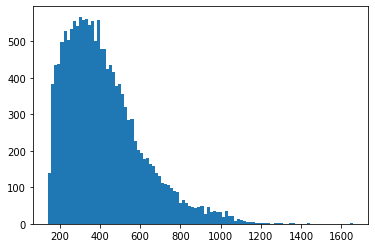

In [36]:
if LOAD_TOKENS_FROM is None:
    plt.hist(train_lens,bins=100)
    plt.show()



From the histogram of train token counts above, we see that using a transformer width of 1024 is a good comprise of capturing most of the data's signal but not having too large a model. We could probably explore other widths between 512 and 1024 also. Or we could use widths of size 512 or smaller and use a stride which breaks a single text into multiple chunks (with possible overlap).

In [37]:
if LOAD_TOKENS_FROM is None:
    targets = np.zeros((len(IDS),MAX_LEN,15), dtype='int32')
    for k in range(7):
        targets[:,:,2*k] = targets_b[k]
        targets[:,:,2*k+1] = targets_i[k]
    targets[:,:,14] = 1-np.max(targets,axis=-1)

In [38]:
if LOAD_TOKENS_FROM is None:
    np.save(f'targets_{MAX_LEN}', targets)
    np.save(f'tokens_{MAX_LEN}', train_tokens)
    np.save(f'attention_{MAX_LEN}', train_attention)
    print('Saved NER tokens')
else:
    targets = np.load(f'{LOAD_TOKENS_FROM}/targets_{MAX_LEN}.npy')
    train_tokens = np.load(f'{LOAD_TOKENS_FROM}/tokens_{MAX_LEN}.npy')
    train_attention = np.load(f'{LOAD_TOKENS_FROM}/attention_{MAX_LEN}.npy')
    print('Loaded NER tokens')

Saved NER tokens


# Build Model
We will use LongFormer backbone and add our own NER head using one hidden layer of size 256 and one final layer with softmax. We use 15 classes because we have a `B` class and `I` class for each of 7 labels. And we have an additional class (called `O` class) for tokens that do not belong to one of the 14 classes.

In [39]:
# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

#     def __init__(self, d_model, warmup_steps=500):
#         super(CustomSchedule, self).__init__()

#         self.d_model = d_model
#         self.d_model = tf.cast(self.d_model, tf.float32)

#         self.warmup_steps = warmup_steps

#     def __call__(self, step):
#         arg1 = tf.math.rsqrt(step)
#         arg2 = step * (self.warmup_steps**-1.5)

#         return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
# learning_rate = CustomSchedule(20000)

# optimizer = tf.keras.optimizers.Adam(
#     learning_rate, beta_1=0.9, beta_2=0.99, epsilon=1e-8, )

In [40]:
# boundaries = [500, 3000]
# values = [1e-4, 1e-5, 1e-6]
# learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)

In [41]:
import tensorflow_addons as tfa
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

In [42]:
# !pip install tensorflow_addons

In [97]:
def build_model():
    
    tokens = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'attention', dtype=tf.int32)
    
    config = AutoConfig.from_pretrained(DOWNLOADED_MODEL_PATH+'/config.json') 
    backbone = TFAutoModel.from_pretrained(DOWNLOADED_MODEL_PATH+'/tf_model.h5', config=config, trainable=True)
    
    x = backbone(tokens, attention_mask=attention)
    x = tf.keras.layers.Dense(512, activation='relu')(x[0])
    x = tf.keras.layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.12e-4),
                  loss =tf.keras.losses.CategoricalCrossentropy(),
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
    return model

In [98]:
with strategy.scope():
    model = build_model()

All model checkpoint layers were used when initializing TFLongformerModel.

All the layers of TFLongformerModel were initialized from the model checkpoint at model/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


In [91]:
# print(model.summary())

# Train or Load Model
If you provide a path in variable `LOAD_MODEL_FROM` above, then it will load your previously trained model. Otherwise it will train now. 

We train 5 epochs of batch size 32 using learning rate `1e-4` for the first four and `1e-5` for the last epoch. I trained my model offline. If you wish to train on Kaggle's GPU, we may need to reduce the batch size. If we reduce the batch size to 8. That is 1/4 original. So we should also reduce the learning rates to `0.25e-4` and `0.25e-5`.

In [99]:
# TRAIN VALID SPLIT 90% 10%
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)),int(0.9*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)
np.random.seed(None)
print('Train size',len(train_idx),', Valid size',len(valid_idx))

Train size 14034 , Valid size 1560


In [100]:
# # LEARNING RATE SCHEDULE AND MODEL CHECKPOINT
EPOCHS = 5
LRS = [0.12e-4, 0.12e-4, 0.12e-4, 0.12e-5, 0.12e-6]
def lrfn(epoch):
    return LRS[epoch]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)



In [101]:
# # LOAD MODEL
# if LOAD_MODEL_FROM:
#     model.load_weights(f'{LOAD_MODEL_FROM}/long_v14.h5')
    
# # OR TRAIN MODEL
# else:
#     model.fit(x = [train_tokens[train_idx,], train_attention[train_idx,]],
#           y = targets[train_idx,],
#           validation_data = ([train_tokens[valid_idx,], train_attention[valid_idx,]],
#                              targets[valid_idx,]),
#           callbacks = [lr_callback],
#           epochs = 5,
#           batch_size = 4,
#           verbose = 1)

#     # SAVE MODEL WEIGHTS
#     model.save_weights(f'long_v{VER}.h5')

In [102]:
def get_preds(dataset='train', verbose=True, text_ids=IDS[valid_idx], preds=oof_preds):
    all_predictions = []

    for id_num in range(len(preds)):
    
        # GET ID
        if (id_num%100==0)&(verbose): 
            print(id_num,', ',end='')
        n = text_ids[id_num]
    
        # GET TOKEN POSITIONS IN CHARS
        name = f'{dataset}/{n}.txt'
        txt = open(name, 'r').read()
        
        '''txt = txt.replace(' .', '. ')
        txt = txt.replace(' ,', ', ')'''
        
        tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
        off = tokens['offset_mapping']
    
        # GET WORD POSITIONS IN CHARS
        w = []
        blank = True
        for i in range(len(txt)):
            if (txt[i]!=' ')&(txt[i]!='\n')&(txt[i]!='\xa0')&(txt[i]!='\x85')&(blank==True):
                w.append(i)
                blank=False
            elif (txt[i]==' ')|(txt[i]=='\n')|(txt[i]=='\xa0')|(txt[i]=='\x85'):
                blank=True
        w.append(1e6)
            
        # MAPPING FROM TOKENS TO WORDS
        word_map = -1 * np.ones(MAX_LEN,dtype='int32')
        w_i = 0
        for i in range(len(off)):
            if off[i][1]==0: continue #ignore first blank
            while off[i][0]>=w[w_i+1]: w_i += 1
            word_map[i] = int(w_i)
        
        # CONVERT TOKEN PREDICTIONS INTO WORD LABELS
        # KEY:
        # 0: LEAD_B, 1: LEAD_I
        # 2: POSITION_B, 3: POSITION_I
        # 4: EVIDENCE_B, 5: EVIDENCE_I
        # 6: CLAIM_B, 7: CLAIM_I
        # 8: CONCLUSION_B, 9: CONCLUSION_I
        # 10: COUNTERCLAIM_B, 11: COUNTERCLAIM_I
        # 12: REBUTTAL_B, 13: REBUTTAL_I
        # 14: NOTHING i.e. O
        pred = preds[id_num,]/2.0
    
        i = 0
        while i<MAX_LEN:
            prediction = []
            start = pred[i]
            if start in [0,1,2,3,4,5,6,7]:
                prediction.append(word_map[i])
                i += 1
                if i>=MAX_LEN: break
                while pred[i]==start+0.5:
                    if not word_map[i] in prediction:
                        prediction.append(word_map[i])
                    i += 1
                    if i>=MAX_LEN: break
            else:
                i += 1
            prediction = [x for x in prediction if x!=-1]
            if len(prediction)>=4:
                all_predictions.append( (n, target_map_rev[int(start)], 
                                ' '.join([str(x) for x in prediction]) ) )
                
    # MAKE DATAFRAME
    df = pd.DataFrame(all_predictions)
    df.columns = ['id','class','predictionstring']
    
    return df

In [103]:
# CODE FROM : Rob Mulla @robikscube
# https://www.kaggle.com/robikscube/student-writing-competition-twitch
def calc_overlap(row):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    set_pred = set(row.predictionstring_pred.split(' '))
    set_gt = set(row.predictionstring_gt.split(' '))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter/ len_pred
    return [overlap_1, overlap_2]


def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id','discourse_type','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df = pred_df[['id','class','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on=['id','class'],
                           right_on=['id','discourse_type'],
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    joined['predictionstring_gt'] = joined['predictionstring_gt'].fillna(' ')
    joined['predictionstring_pred'] = joined['predictionstring_pred'].fillna(' ')

    joined['overlaps'] = joined.apply(calc_overlap, axis=1)

    # 2. If the overlap between the ground truth and prediction is >= 0.5, 
    # and the overlap between the prediction and the ground truth >= 0.5,
    # the prediction is a match and considered a true positive.
    # If multiple matches exist, the match with the highest pair of overlaps is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])


    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1','overlap2']].max(axis=1)
    tp_pred_ids = joined.query('potential_TP') \
        .sort_values('max_overlap', ascending=False) \
        .groupby(['id','predictionstring_gt']).first()['pred_id'].values

    # 3. Any unmatched ground truths are false negatives
    # and any unmatched predictions are false positives.
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]

    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    # Get numbers of each type
    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    #calc microf1
    my_f1_score = TP / (TP + 0.5*(FP+FN))
    return my_f1_score

In [104]:
for i in range(5):
    print(i)
    model.fit(x = [train_tokens[train_idx,], train_attention[train_idx,]],
          y = targets[train_idx,],
          validation_data = ([train_tokens[valid_idx,], train_attention[valid_idx,]],
                             targets[valid_idx,]),
          callbacks = [lr_callback],
          epochs = 1,
          batch_size = 4,
          verbose = 1)

    # SAVE MODEL WEIGHTS
    model.save_weights(f'long_v{i}.h5')
    p = model.predict([train_tokens[valid_idx,], train_attention[valid_idx,]], 
                  batch_size=16, verbose=2)
    print('OOF predictions shape:',p.shape)
    oof_preds = np.argmax(p,axis=-1)
    target_map_rev = {0:'Lead', 1:'Position', 2:'Evidence', 3:'Claim', 4:'Concluding Statement',
             5:'Counterclaim', 6:'Rebuttal', 7:'blank'}
    
    oof = get_preds( dataset='train', verbose=True, text_ids=IDS[valid_idx] )
    oof.head()
    
    # VALID DATAFRAME
    valid = train.loc[train['id'].isin(IDS[valid_idx])]
    f1s = []
    CLASSES = oof['class'].unique()
    for c in CLASSES:
        pred_df = oof.loc[oof['class']==c].copy()
        gt_df = valid.loc[valid['discourse_type']==c].copy()
        f1 = score_feedback_comp(pred_df, gt_df)
        print(c,f1)
        f1s.append(f1)
    print()
    print('Overall',np.mean(f1s))
    

0

Epoch 1: LearningRateScheduler setting learning rate to 1.2e-05.


2022-02-19 15:10:16.241172: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2172] Converted 4944/23242 nodes to float16 precision using 593 cast(s) to float16 (excluding Const and Variable casts)


3509/3509 [==============================] - ETA: 0s - loss: 0.3732 - categorical_accuracy: 0.8831

2022-02-19 15:37:06.766251: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2172] Converted 2095/4335 nodes to float16 precision using 111 cast(s) to float16 (excluding Const and Variable casts)


3509/3509 [==============================] - 1707s 469ms/step - loss: 0.3732 - categorical_accuracy: 0.8831 - val_loss: 0.3083 - val_categorical_accuracy: 0.8996 - lr: 1.2000e-05


2022-02-19 15:38:06.242561: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2172] Converted 2403/6645 nodes to float16 precision using 124 cast(s) to float16 (excluding Const and Variable casts)


98/98 - 78s - 78s/epoch - 793ms/step
OOF predictions shape: (1560, 1024, 15)
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , Lead 0.5660138976626659
Evidence 0.2504996668887408
Concluding Statement 0.39499455930359084
Claim 0.033224990971469845
Position 0.012690355329949238

Overall 0.2514846940312834
1

Epoch 1: LearningRateScheduler setting learning rate to 1.2e-05.
3509/3509 [==============================] - 1635s 466ms/step - loss: 0.2931 - categorical_accuracy: 0.9037 - val_loss: 0.2924 - val_categorical_accuracy: 0.9040 - lr: 1.2000e-05
98/98 - 64s - 64s/epoch - 651ms/step
OOF predictions shape: (1560, 1024, 15)
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , Lead 0.5660138976626659
Evidence 0.2504996668887408
Concluding Statement 0.39499455930359084
Claim 0.033224990971469845
Position 0.012690355329949238

Overall 0.2514846940312834
2

Epoch 1: LearningRateScheduler setting l

KeyboardInterrupt: 

In [ ]:
# model.save_weights(f'long_v{VER}.h5')

# Validate Model - Infer Out of fold (OOF)
We will now make predictions on the validation texts. Our model makes label predictions for each token, we need to convert this into a list of word indices for each label. Note that the tokens and words are not the same. A single word may be broken into multiple tokens. Therefore we need to first create a map to change token indices to word indices.

In [74]:
p = model.predict([train_tokens[valid_idx,], train_attention[valid_idx,]], 
                  batch_size=16, verbose=2)
print('OOF predictions shape:',p.shape)
oof_preds = np.argmax(p,axis=-1)

2022-02-19 14:53:15.780663: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2172] Converted 2403/6645 nodes to float16 precision using 124 cast(s) to float16 (excluding Const and Variable casts)


98/98 - 78s - 78s/epoch - 794ms/step
OOF predictions shape: (1560, 1024, 15)


In [75]:
target_map_rev = {0:'Lead', 1:'Position', 2:'Evidence', 3:'Claim', 4:'Concluding Statement',
             5:'Counterclaim', 6:'Rebuttal', 7:'blank'}

0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 

,id,class,predictionstring
0,DBF7EB6A9E02,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,48D3F4243F0F,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,48D3F4243F0F,Evidence,229 230 231 232 233 234 235 236 237 238 239 24...
3,743904BAD7E5,Evidence,252 253 254 255 256 257 258 259 260 261 262 26...
4,5FD1A8FB7F6C,Evidence,139 140 141 142 143 144 145 146 147 148 149 15...


In [78]:
print('The following classes are present in oof preds:')
oof['class'].unique()

The following classes are present in oof preds:


array(['Lead', 'Evidence', 'Concluding Statement', 'Claim', 'Position'],
      dtype=object)

# Compute Validation Metric
The following code is from Rob Mulla's excellent notebook [here][2]. Our LongFormer single fold model achieves CV score 0.617! Hooray!

[2]: https://www.kaggle.com/robikscube/student-writing-competition-twitch

Lead 0.5660138976626659
Evidence 0.2504996668887408
Concluding Statement 0.39499455930359084
Claim 0.033224990971469845
Position 0.012690355329949238

Overall 0.2514846940312834


In [ ]:
# distil roberta base 128, 8 epocs from 1e-4 to 1e-8 Overall 0.5391855568785594
# distil roberta base 512, 5 epocs from 1e-4 to 1e-6 Overall 0.542305764914767
# distil roberta base 512, 5 epocs adamw 1e-4 decay OverallOverall 0.42874356353168075
# tf roberta base 512, 5 epocs 5 epocs from 1e-4 to 1e-6 OverallOverall 0.42874356353168075
longformer base 42?????
longformer base 2048 allen 31 1 epochs?????

# Infer Test Data
We will now infer the test data and create a submission. Our CV is 0.617, let's see what our LB is!

In [105]:
# GET TEST TEXT IDS
files = os.listdir('test')
TEST_IDS = [f.replace('.txt','') for f in files if 'txt' in f]
print('There are',len(TEST_IDS),'test texts.')

There are 5 test texts.


In [107]:
# CONVERT TEST TEXT TO TOKENS
test_tokens = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')
test_attention = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')

for id_num in range(len(TEST_IDS)):
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = TEST_IDS[id_num]
    name = f'test/{n}.txt'
    txt = open(name, 'r').read()
    
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    test_tokens[id_num,] = tokens['input_ids']
    test_attention[id_num,] = tokens['attention_mask']

In [108]:
# INFER TEST TEXTS
p = model.predict([test_tokens, test_attention], 
                  batch_size=16, verbose=2)
print('Test predictions shape:',p.shape)
test_preds = np.argmax(p,axis=-1)

1/1 - 0s - 246ms/epoch - 246ms/step
Test predictions shape: (5, 1024, 15)


In [109]:
# GET TEST PREDICIONS
sub = get_preds( dataset='test', verbose=False, text_ids=TEST_IDS, preds=test_preds )
sub.head()

,id,class,predictionstring
0,0FB0700DAF44,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,0FB0700DAF44,Position,41 42 43 44 45 46 47
2,0FB0700DAF44,Claim,49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
3,0FB0700DAF44,Claim,66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 8...
4,0FB0700DAF44,Position,108 109 110 111 112 113 114 115 116 117 118 119


# Post processing

In [110]:
import os
files = os.listdir('test')
TEST_IDS = [f.replace('.txt','') for f in files if 'txt' in f]
for id_num in range(len(TEST_IDS)):
        
    n = TEST_IDS[id_num]
    name = f'test/{n}.txt'
    txt = open(name, 'r').read()
    
    txt = txt.replace('?','.')
    phrases = txt.split('.')[0:-1]
    
    phrase_start = [0]
    for phrase in phrases:
        phrase_len = len(phrase.split())
        phrase_start.append(phrase_start[-1]+phrase_len)
        
    '''print(phrase_start)
    print(' '.join(txt.split()[65:84]))'''
    predstrings = sub.loc[sub.id==TEST_IDS[id_num]]['predictionstring']
    
    corr_predstrings=[]
    for i, predstring in enumerate(predstrings):
        predstart = int(predstring.split()[0])
        predend = int(predstring.split()[-1])
        
        for j in range(len(phrase_start)-1):
            if (predstart > phrase_start[j]) & (predstart < phrase_start[j+1]):
                predstart = phrase_start[j]
            if (predend > phrase_start[j]) & (predend < phrase_start[j+1]):
                predend = phrase_start[j+1]
            
        predstring = ' '.join([str(val) for val in range(predstart,predend)])
        corr_predstrings.append(predstring)
    
    sub.loc[sub.id==TEST_IDS[id_num], 'predictionstring'] = corr_predstrings
    
    
        
sub.head()

,id,class,predictionstring
0,0FB0700DAF44,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,0FB0700DAF44,Position,41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 5...
2,0FB0700DAF44,Claim,41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 5...
3,0FB0700DAF44,Claim,65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 8...
4,0FB0700DAF44,Position,108 109 110 111 112 113 114 115 116 117 118 119


# Write Submission CSV

In [111]:
# WRITE SUBMISSION CSV
sub.to_csv('submission.csv',index=False)